# Calculate a linear hydrogen/helium mixture

We calculate EOS tables for mixtures of two components using the Additive Volume Law (AVL). The AVL is based on the additivity of extensive thermodynamical quantities (e.g., volume, internal energy or entropy) at constant intensive variables (pressure and temperature). In case of a hydrogen (H) / helium (He) mixture the density, internal energy and entropy of the mixture are given by
$$
\begin{eqnarray}
\frac{1}{\rho \left( P, T \right)} & = & \frac{1-Y}{\rho_H \left( P, T \right)} + \frac{Y}{\rho_{He} \left( P, T \right)}\\
u \left( P, T \right)              & = & \left( 1-Y \right) u_H \left( P, T \right) + Y u_{He} \left( P, T \right)
\end{eqnarray}
$$
for a given helium mass fraction $Y$.

### Import modules

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate as interp
from scipy import optimize
import numpy as np

In [3]:
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [4]:
mpl.rcParams['figure.dpi'] = 100

In [5]:
def read_eos_table_pt(filename):
    data = np.loadtxt(filename) 

    logT_table   = data[:, 0]
    logP_table   = data[:, 1]
    frac_H2      = data[:, 2]
    frac_H       = data[:, 3]
    logrho_table = data[:, 4]
    logu_table   = data[:, 5]
    logs_table   = data[:, 6]

    # All the SCvH EOS tables are tabulated along isotherms (which have all the same range in T and number of grid points)
    logT_axis = np.unique(logT_table)
    nT = np.size(logT_axis)

    print("Input: {:}".format(filename))
    print("Number of isotherms: nT = {:}".format(nT))

    # The number of grid points in P are different for each isotherm
    logP_axis = list()
    logrho = list()
    logu = list()
    logs = list()

    for logT in logT_axis:
        logP_axis.append(logP_table[np.where(logT_table == logT)])
        logrho.append(logrho_table[np.where(logT_table == logT)])
        logu.append(logu_table[np.where(logT_table == logT)])
        logs.append(logs_table[np.where(logT_table == logT)])

    logT_min = np.min(logT_axis)
    logT_max = np.max(logT_axis)

    print("logT_min = {:}".format(logT_min))
    print("logT_max = {:}".format(logT_max))
    print()
    
    # Generate 1D interpolation functions for each isotherm
    logrho_of_logP_int = list()
    logu_of_logP_int = list()
    logs_of_logP_int = list()

    for i in range(0, nT):
        logrho_of_logP_int.append(interp.InterpolatedUnivariateSpline(logP_axis[i], logrho[i], k=1, ext='extrapolate'))
        logu_of_logP_int.append(interp.InterpolatedUnivariateSpline(logP_axis[i], logu[i], k=1, ext='extrapolate'))
        logs_of_logP_int.append(interp.InterpolatedUnivariateSpline(logP_axis[i], logs[i], k=1, ext='extrapolate'))
        """
        logrho_of_logP_int.append(interp.CubicSpline(logP_table_axis[i], logrho_isotherm[i], extrapolate=True))
        logu_of_logP_int.append(interp.CubicSpline(logP_table_axis[i], logu_isotherm[i], extrapolate=True))
        logs_of_logP_int.append(interp.CubicSpline(logP_table_axis[i], logs_isotherm[i], extrapolate=True))
        """
        """
        logrho_of_logP_int.append(interp.PchipInterpolator(logP_table_axis[i], logrho_isotherm[i], extrapolate=True))
        logu_of_logP_int.append(interp.PchipInterpolator(logP_table_axis[i], logu_isotherm[i], extrapolate=True))
        logs_of_logP_int.append(interp.PchipInterpolator(logP_table_axis[i], logs_isotherm[i], extrapolate=True))
        """

    eos_table_pt = {
        "nT":         nT,
        "logP_axis":  logP_axis,
        "logT_axis":  logT_axis,
        "logrho":     logrho,
        "logu":       logu,
        "logs":       logs,
        "logrho_int": logrho_of_logP_int,
        "logu_int":   logu_of_logP_int,
        "logs_int":   logs_of_logP_int,
    }
    
    return eos_table_pt

In [15]:
# Write the EOS table to an output file
def write_eos_table_pt(filename, logP_axis, logT_axis, logrho, logu, logs, delimiter=",", comments="#"):
    nT = np.size(logT_axis)
    
    # Store the different isotherms in 1d arrays
    logTrho = np.tile(logrho_axis, nT)
    logT = np.repeat(logT_axis, nRho)
    
    logP = np.concatenate(logP_axis[i])


    logrho = np.concatenate(logrho)
    logu = np.concatenate(logu)
    logs = np.concatenate(logs)

    header = "nT = {:} nRho= {:}\n"\
             "{:},{:},{:},{:},{:}".format(nT, nRho, "logT [K]", "logRho [g/cc]", "logP [barye]", "logE [erg/g]", "logS [erg/g/K]")
    
    np.savetxt(filename, np.column_stack([logT, logrho, logP, logu, logs]), header=header, fmt='%15.8e', delimiter=delimiter, comments=comments)
    

In [16]:
# Load the two EOS tables
scvh_h_pt = read_eos_table_pt("hydrogen_scvh_extended.data")
scvh_he_pt = read_eos_table_pt("helium_scvh_extended.data")

# Check if logT and logP axis agrees between the two EOS tables
if scvh_h_pt['nT'] != scvh_he_pt['nT']:
    print("Different number of isotherms.")

if np.size(np.where(np.abs(scvh_h_pt['logT_axis']-scvh_he_pt['logT_axis']) > 1e-6)) != 0:
    print("logT axis differ between the two EOS.")

for i in range(scvh_h_pt['nT']):
    if np.size(np.where(np.abs(scvh_h_pt['logP_axis'][i]-scvh_he_pt['logP_axis'][i]) > 1e-6)) != 0:
        print("Isotherm i={:} logT={:}: logP axis differ between the two EOS.".format(i, scvh_h_pt['logT_axis'][i]))

Input: hydrogen_scvh_extended.data
Number of isotherms: nT = 76
logT_min = 1.06
logT_max = 7.06

Input: helium_scvh_extended.data
Number of isotherms: nT = 76
logT_min = 1.06
logT_max = 7.06



In [18]:
def calc_mixing_h_he_rho(scvh_h_pt, scvh_he_pt, P, logT_index, Y=0.275):
    rho_mix_inv = (1.0 - Y)/scvh_h_pt['logrho_of_logP_int'][logT_index](P) + Y/scvh_he_pt['logrho_of_logP_int'][logT_index](P)
    return 1.0/rho_mix_inv

In [19]:
def calc_mixing_h_he_ru(scvh_h_pt, scvh_he_pt, P, logT_index, Y=0.275):
    u_mix = (1.0 - Y)*scvh_h_pt['logu_of_logP_int'][logT_index](P) + Y*scvh_he_pt['logu_of_logP_int'][logT_index](P)
    return u_mix

In [20]:
# Calculate a H-He mixture for each isotherm
logT_mix = scvh_h_pt['logT_axis']
logP_mix = scvh_h_pt['logP_axis']

# Note that we assume that both EOS tables have the same logT axis
nT_mix = np.size(logT_mix)

logrho_mix = list()
logu_mix = list()
logs_mix = list()

for i in range(nT_mix):
    logrho_mix.append(calc_mixing_h_he_rho(scvh_h_pt, scvh_he_pt, logP_min[i], i))
    logu_mix.append(calc_mixing_h_he_u(scvh_h_pt, scvh_he_pt, logP_min[i], i))




In [8]:
# Skip some curves otherwise the plots are very hard to read
nSkipT = 5
nSkipRho = 10

[Text(0.5, 0, 'log(P) [erg cm$^{-3}$]'),
 Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

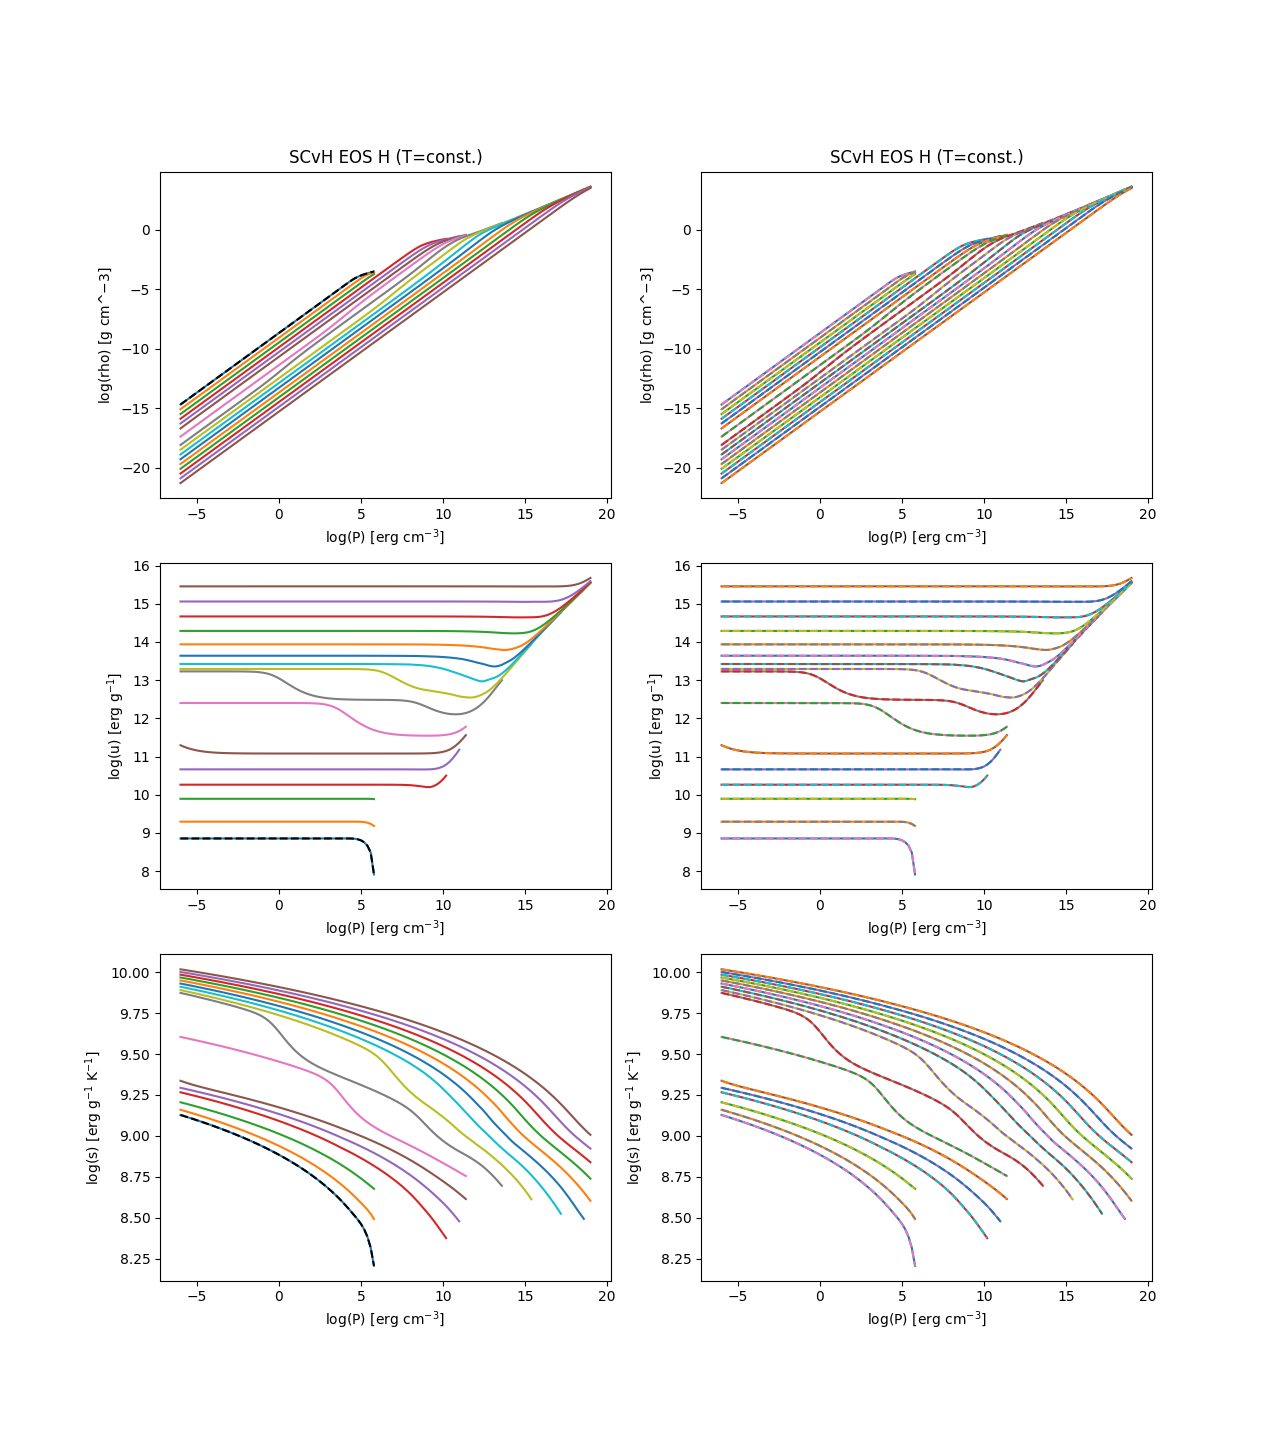

In [9]:
# Plot log(rho), log(u) and log(s)
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

# rho(P, T=const)
for i in range(0, nT, nSkipT):
    ax[0][0].plot(logP_table_axis[i], logrho_isotherm[i], '-')
    
ax[0][0].plot(logP_table_axis[0], logrho_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[0][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(rho) [g cm^${-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# Interpolated for T=const.
#plt.gca().set_prop_cycle(None)

for i in range(0, nT, nSkipT):
    ax[0][1].plot(logP_table_axis[i], logrho_isotherm[i], '-')

#plt.gca().set_prop_cycle(None)

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[0][1].plot(logP, logrho_of_logP_int[i](logP), '--')

ax[0][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(rho) [g cm^${-3}$]")
ax[0][1].set(title="SCvH EOS H (T=const.)")

# u(P, T=const)
for i in range(0, nT, nSkipT):
    ax[1][0].plot(logP_table_axis[i], logu_isotherm[i], '-')
    
ax[1][0].plot(logP_table_axis[0], logu_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[1][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# Interpolated for T=const.
for i in range(0, nT, nSkipT):
    ax[1][1].plot(logP_table_axis[i], logu_isotherm[i], '-')

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[1][1].plot(logP, logu_of_logP_int[i](logP), '--')

ax[1][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# s(P, T=const)
for i in range(0, nT, nSkipT):
    ax[2][0].plot(logP_table_axis[i], logs_isotherm[i], '-')
    
ax[2][0].plot(logP_table_axis[0], logs_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[2][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# Interpolated for T=const.
for i in range(0, nT, nSkipT):
    ax[2][1].plot(logP_table_axis[i], logs_isotherm[i], '-')

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[2][1].plot(logP, logs_of_logP_int[i](logP), '--')

ax[2][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


[Text(0.5, 0, 'log(P) [erg cm$^{-3}$]'),
 Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

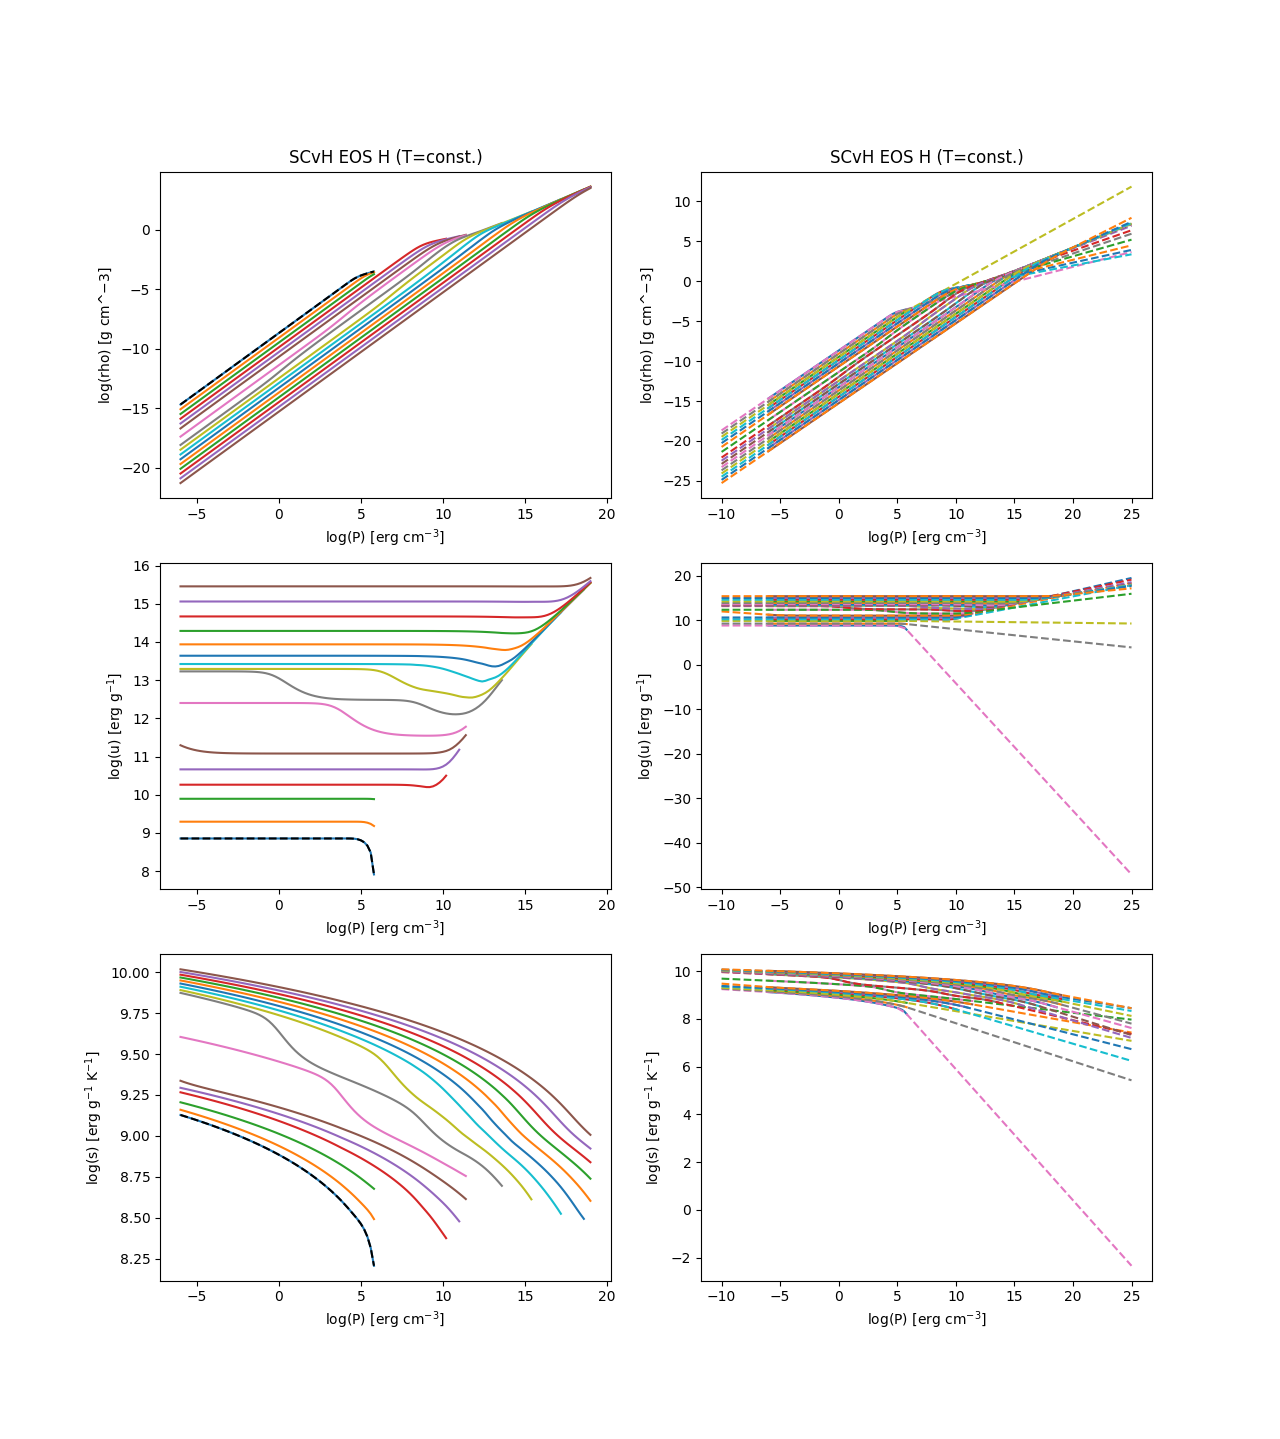

In [10]:
# Plot extrapolated log(rho), log(u) and log(s)
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

logP_axis_extrap = np.linspace(-10, 25)

# rho(P, T=const)
for i in range(0, nT, nSkipT):
    ax[0][0].plot(logP_table_axis[i], logrho_isotherm[i], '-')
    
ax[0][0].plot(logP_table_axis[0], logrho_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[0][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(rho) [g cm^${-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# Interpolated for T=const.
#plt.gca().set_prop_cycle(None)

for i in range(0, nT, nSkipT):
    ax[0][1].plot(logP_table_axis[i], logrho_isotherm[i], '-')

#plt.gca().set_prop_cycle(None)

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[0][1].plot(logP_axis_extrap, logrho_of_logP_int[i](logP_axis_extrap), '--')

ax[0][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(rho) [g cm^${-3}$]")
ax[0][1].set(title="SCvH EOS H (T=const.)")

# u(P, T=const)
for i in range(0, nT, nSkipT):
    ax[1][0].plot(logP_table_axis[i], logu_isotherm[i], '-')
    
ax[1][0].plot(logP_table_axis[0], logu_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[1][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# Interpolated for T=const.
for i in range(0, nT, nSkipT):
    ax[1][1].plot(logP_table_axis[i], logu_isotherm[i], '-')

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[1][1].plot(logP_axis_extrap, logu_of_logP_int[i](logP_axis_extrap), '--')

ax[1][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# s(P, T=const)
for i in range(0, nT, nSkipT):
    ax[2][0].plot(logP_table_axis[i], logs_isotherm[i], '-')
    
ax[2][0].plot(logP_table_axis[0], logs_isotherm[0], '--', color='black', label=r"T$_{min}$")

ax[2][0].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# Interpolated for T=const.
for i in range(0, nT, nSkipT):
    ax[2][1].plot(logP_table_axis[i], logs_isotherm[i], '-')

for i in range(0, nT, nSkipT):
    logP = np.linspace(np.min(logP_table_axis[i]), np.max(logP_table_axis[i]), 1000)
    ax[2][1].plot(logP_axis_extrap, logs_of_logP_int[i](logP_axis_extrap), '--')

ax[2][1].set(xlabel="log(P) [erg cm$^{-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


In [11]:
def func_logrho(logP, logrho_of_logP_int, logrho_i):
    """
    Calculate logrho(logP, logT=const) - logrho_i.
    """
    return logrho_of_logP_int(logP)-logrho_i

In [12]:
# Test if root finding works
logrho_of_logP = logrho_of_logP_int[0]
logrho_int = logrho_isotherm[0][1]

logP_min = np.min(logP_table_axis[0])
logP_max = np.max(logP_table_axis[0])

print(logP_min)
print(logP_max)



sol = optimize.root_scalar(func_logrho, args=(logrho_of_logP_int[0], logrho_isotherm[0][1]), bracket=[-100, 100], method='brentq')

logP_of_logrho = sol.root

print("rho= {:}: P= {:} err= {:}".format(logrho_int, logP_of_logrho, (logP_of_logrho-logP_table_axis[0][1])/logP_of_logrho))
#sol = optimize.root_scalar(func_logrho, args=(logrho_of_logP, logrho_int), bracket=[0, 100], method='brentq')

-6.0
5.8
rho= -14.4805: P= -5.799999999999973 err= -4.594026308793773e-15


In [13]:
# Invert an isotherm from logrho(logP) to logP(logrho)
def inv_isotherm_logrho(logrho_axis, logrho_of_logP_int, logP_min=-100, logP_max=100):
    nRho = np.size(logrho_axis)
    
    logP_of_logrho = np.zeros(nRho)
    
    # This is shitty but it seems that root_scalar does not work with an array of inputs
    for i in range(nRho):
        sol = optimize.root_scalar(func_logrho, args=(logrho_of_logP_int, logrho_axis[i]), bracket=[logP_min, logP_max], method='brentq')
        logP_of_logrho[i] = sol.root
        
    return logP_of_logrho

In [14]:
# Test the function inv_isotherm_logrho()
index = 0

logrho_of_logP = logrho_of_logP_int[index]
logrho_int = logrho_isotherm[index][1]

logP_min = np.min(logP_table_axis[index])
logP_max = np.max(logP_table_axis[index])

logrho_min = np.min(logrho_isotherm[index])
logrho_max = np.max(logrho_isotherm[index])

print("logP_min= {:} logP_max= {:}".format(logP_min, logP_max))
print("logrho_min= {:} logrho_max= {:}".format(logrho_min, logrho_max))


logrho_axis = np.linspace(logrho_min, logrho_max, 100)

logP_isotherm = inv_isotherm_logrho(logrho_axis, logrho_of_logP)

"""
print("logrho_axis= {:}".format(logrho_axis))
print()
print("logP={:}".format(logP_isotherm))
"""

logP_min= -6.0 logP_max= 5.8
logrho_min= -14.6805 logrho_max= -3.5134


'\nprint("logrho_axis= {:}".format(logrho_axis))\nprint()\nprint("logP={:}".format(logP_isotherm))\n'

In [15]:
# Write the inverted EOS table to an output file
def write_eos_table(filename, logrho_axis, logT_axis, logP, logu, logs, delimiter=",", comments="#"):
    nRho = np.size(logrho_axis)
    nT = np.size(logT_axis)
    
    # Store the different isotherms in 1d arrays
    logrho = np.tile(logrho_axis, nT)
    logT = np.repeat(logT_axis, nRho)

    #logP = logP_array.flatten(order='C')
    #logu = logu_array.flatten(order='C')
    #logs = logs_array.flatten(order='C')   

    header = "nT = {:} nRho= {:}\n"\
             "{:},{:},{:},{:},{:}".format(nT, nRho, "logT [K]", "logRho [g/cc]", "logP [barye]", "logE [erg/g]", "logS [erg/g/K]")
    
    np.savetxt(filename, np.column_stack([logT, logrho, logP, logu, logs]), header=header, fmt='%15.8e', delimiter=delimiter, comments=comments)
    

In [16]:
# Invert logrho(logP, logT) for a given logrho_axis
logrho_axis_min = -15.0
logrho_axis_max = 2.0

logrho_axis = np.linspace(logrho_axis_min, logrho_axis_max)

logP_of_logrho = list()
logu_of_logrho = list()
logs_of_logrho = list()

# Invert each isotherm
for i in range(nT):
    logP_of_logrho.append(inv_isotherm_logrho(logrho_axis, logrho_of_logP_int[i]))
    logu_of_logrho.append(logu_of_logP_int[i](logP_of_logrho[i]))
    logs_of_logrho.append(logs_of_logP_int[i](logP_of_logrho[i]))

    logP_min = np.min(logP_table_axis[index])
    logP_max = np.max(logP_table_axis[index])

    #print("Isotherm {:} (logT={:.2f}):".format(i, logT_table_axis[i]))
    #print("logP_min= {:} logP_max= {:}".format(logP_min, logP_max))
    #print("P(rho)={:}".format(logP_of_logrho[i]))

# Generate 1D numpy arrays
logP_of_logrho_1d = np.concatenate(logP_of_logrho)
logu_of_logrho_1d = np.concatenate(logu_of_logrho)
logs_of_logrho_1d = np.concatenate(logs_of_logrho)

# Generate 2D numpy arrays because these are more convenient to use
logP_array = np.stack(logP_of_logrho)
logu_array = np.stack(logu_of_logrho)
logs_array = np.stack(logs_of_logrho)

write_eos_table("hydrogen_scvh_extended.csv", logrho_axis, logT_table_axis, logP_of_logrho_1d, logu_of_logrho_1d, logs_of_logrho_1d)


In [17]:
# Load an EOS table assuming that the variables are (rho, T) and that each isotherm has the same number of gridpoints
def load_eos_table(filename, delimiter=",", skiprows=0):
    data = np.loadtxt(filename, delimiter=delimiter, skiprows=skiprows)

    logT_table   = data[:, 0]
    logrho_table = data[:, 1]
    logP_table   = data[:, 2]
    logu_table   = data[:, 3]
    logs_table   = data[:, 4]

    
    # All the SCvH EOS tables are tabulated along isotherms
    #logT_table_axis = np.unique(logT_table)
    #nT = np.size(logT_table_axis)
    
    # All SCVH EOS tables obtained from Ravit have the same size
    nRho = 201
    nT   = 100

    logrho_table = logrho_table[0:nRho]
    logT_table = logT_table[0:np.size(logT_table):nRho]

    logrho_min = np.min(logrho_table)
    logrho_max = np.max(logrho_table)
    logT_min   = np.min(logT_table)
    logT_max   = np.max(logT_table)
    
    dlogrho = logrho_table[1:]-logrho_table[:-1]
    dlogT = logT_table[1:]-logT_table[:-1]
    
    print("Read EOS table: {:}".format(filename))
    print("logrho_min = {:}".format(logrho_min))
    print("logrho_max = {:}".format(logrho_max))
    print("logT_min   = {:}".format(logT_min))
    print("logT_max   = {:}".format(logT_max))
    print()

    # Mark where the original SCvH EOS table was extended below T=100K
    #index = np.min(np.where(logT_table>=2.0))
    #print("The EOS table was extended until index={:} logT={:}".format(index, logT_table[index]))


    # Split into arrays of constant T
    logP_array = np.split(logP_table, nT)
    logu_array = np.split(logu_table, nT)
    logs_array = np.split(logs_table, nT)
    
    # Generate 2d arrays
    logP = np.vstack(logP_array)
    logu = np.vstack(logu_array)
    logs = np.vstack(logs_array)
    
    # Generate 2D interpolation functions for the old EOS tables
    logP_int = interp.interp2d(logrho_table, logT_table, logP, kind='linear')
    logu_int = interp.interp2d(logrho_table, logT_table, logu, kind='linear')
    logs_int = interp.interp2d(logrho_table, logT_table, logs, kind='linear')

    eos_table = {
        "nRho":     nRho,
        "nT":       nT,
        "logrho":   logrho_table,
        "logT":     logT_table,
        "logP":     logP,
        "logu":     logu,
        "logs":     logs,
        "logP_int": logP_int,
        "logu_int": logu_int,
        "logs_int": logs_int,
    }
    
    return eos_table

Read EOS table: scvh_h_dt_cgs.csv
logrho_min = -8.0
logrho_max = 2.0
logT_min   = 1.06
logT_max   = 6.01



[Text(0.5, 0, 'log(T) [K]'), Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

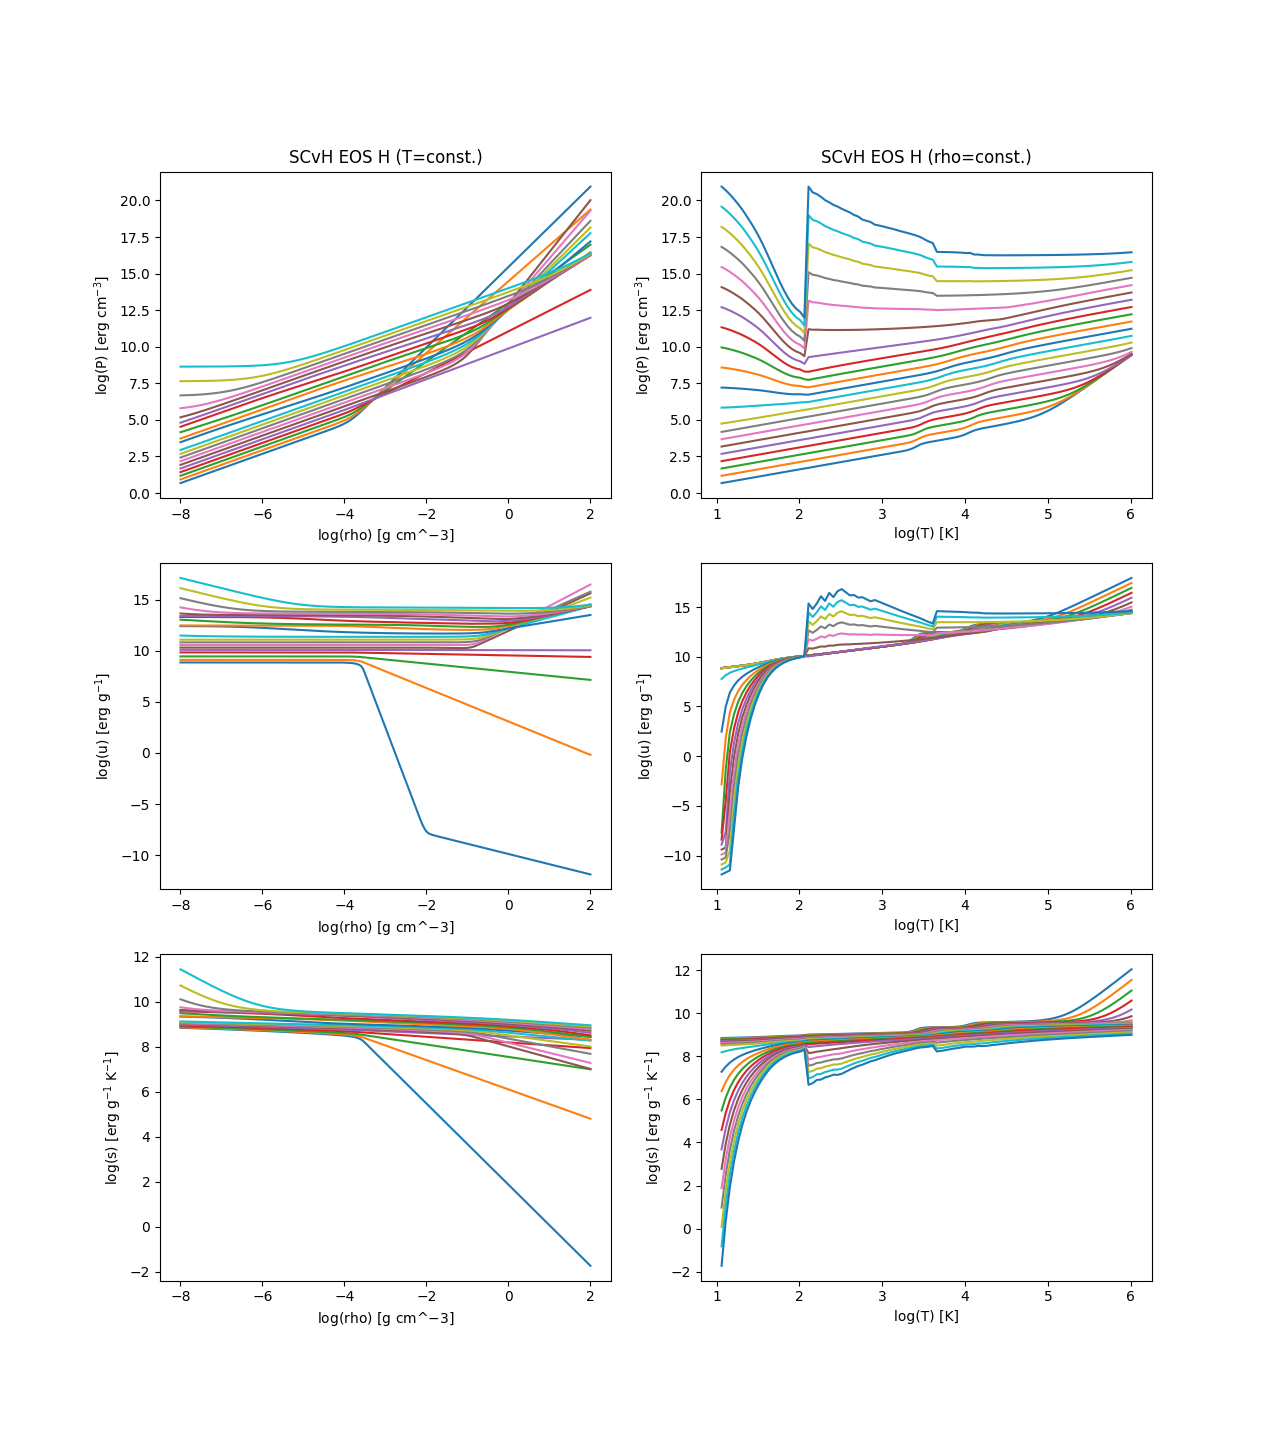

In [18]:
# Test if reading the old EOS tables work
scvheos_h_old = load_eos_table("scvh_h_dt_cgs.csv", skiprows=1)

# Plot curves of log(P), log(u) and log(s)
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)


# P(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[0][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logP"][i,:], '-')
    
ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[0][1].plot(scvheos_h_old["logT"], scvheos_h_old["logP"][:,i], '-')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[1][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logu"][i,:], '-')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[1][1].plot(scvheos_h_old["logT"], scvheos_h_old["logu"][:,i], '-')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[2][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logs"][i,:], '-')

ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[2][1].plot(scvheos_h_old["logT"], scvheos_h_old["logs"][:,i], '-')

ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


Read EOS table: scvh_h_dt_cgs.csv
logrho_min = -8.0
logrho_max = 2.0
logT_min   = 1.06
logT_max   = 6.01



[Text(0.5, 0, 'log(T) [K]'), Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

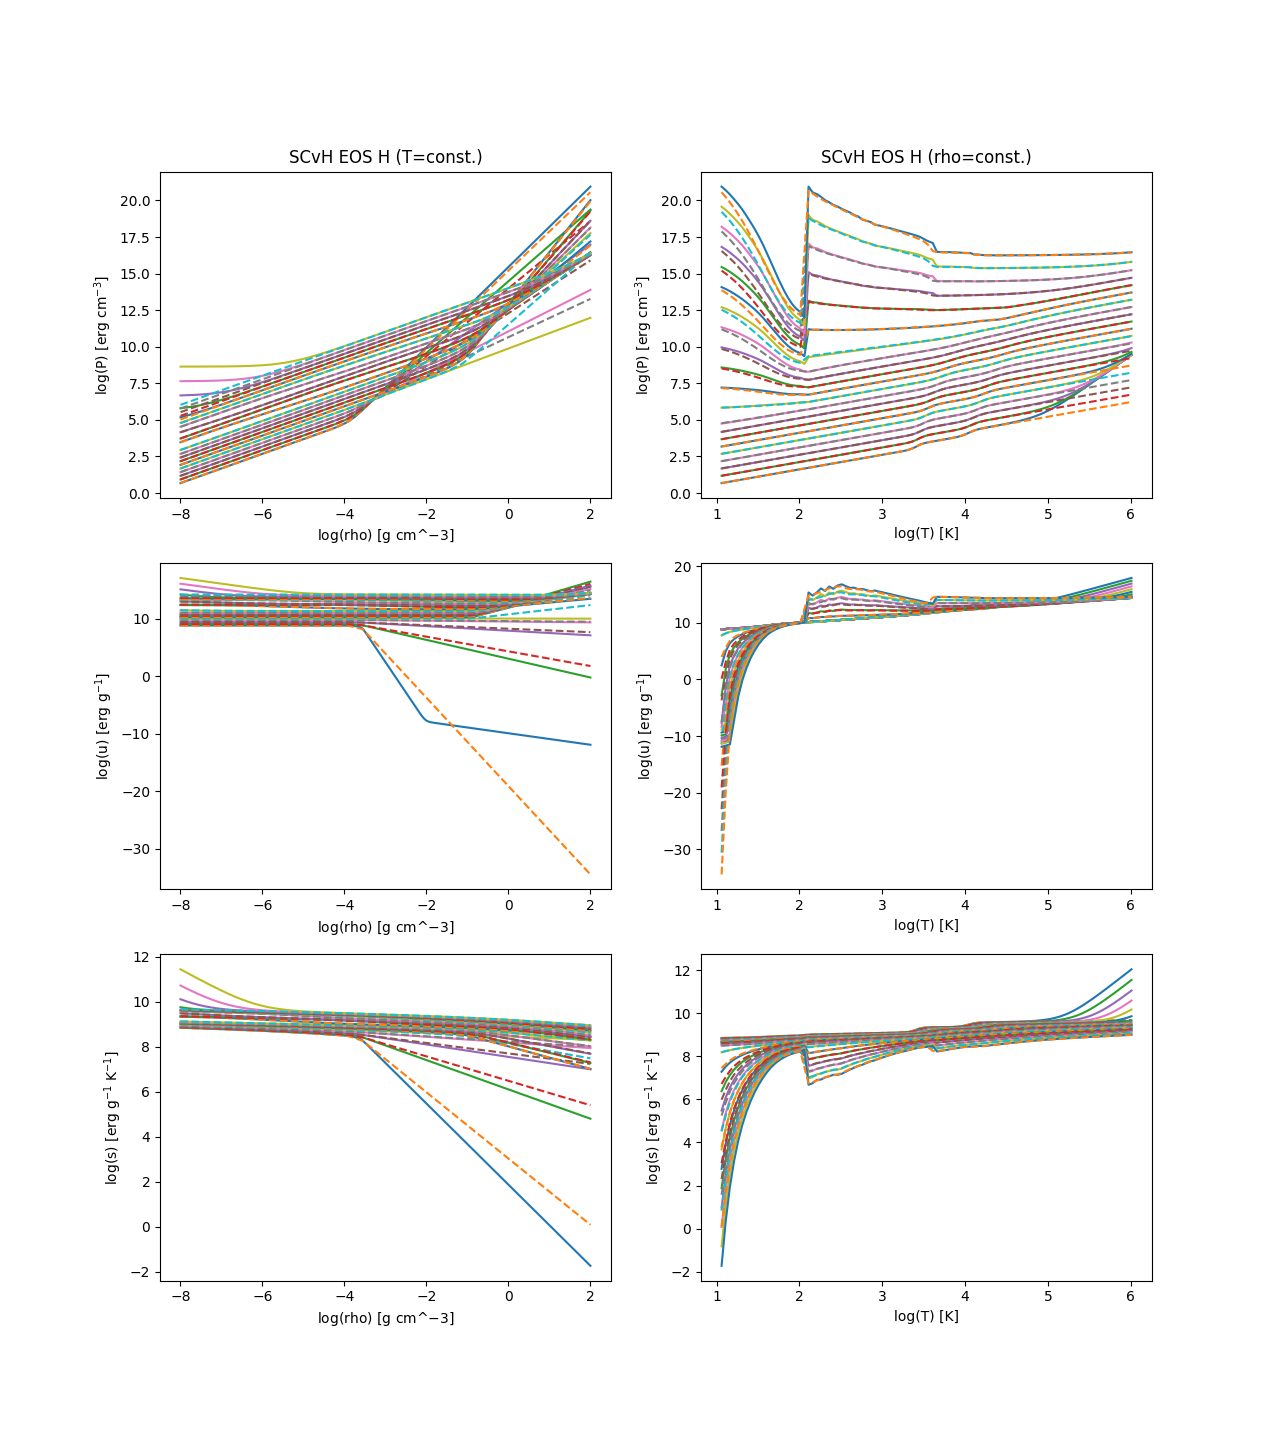

In [19]:
# Compare the inverted EOS table to the tables I obtained from Ravit
scvheos_h_old = load_eos_table("scvh_h_dt_cgs.csv", skiprows=1)

# Generate 2D interpolation functions for the new EOS tables
logP_int = interp.interp2d(logrho_axis, logT_table_axis, logP_array, kind='linear')
logu_int = interp.interp2d(logrho_axis, logT_table_axis, logu_array, kind='linear')
logs_int = interp.interp2d(logrho_axis, logT_table_axis, logs_array, kind='linear')

# Plot curves of log(P), log(u) and log(s)
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

# P(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[0][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logP"][i,:], '-')
    ax[0][0].plot(scvheos_h_old["logrho"], logP_int(scvheos_h_old["logrho"], scvheos_h_old["logT"][i]), '--')

ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[0][1].plot(scvheos_h_old["logT"], scvheos_h_old["logP"][:,i], '-')
    ax[0][1].plot(scvheos_h_old["logT"], logP_int(scvheos_h_old["logrho"][i], scvheos_h_old["logT"]), '--')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[1][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logu"][i,:], '-')
    ax[1][0].plot(scvheos_h_old["logrho"], logu_int(scvheos_h_old["logrho"], scvheos_h_old["logT"][i]), '--')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[1][1].plot(scvheos_h_old["logT"], scvheos_h_old["logu"][:,i], '-')
    ax[1][1].plot(scvheos_h_old["logT"], logu_int(scvheos_h_old["logrho"][i], scvheos_h_old["logT"]), '--')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
for i in range(0, scvheos_h_old["nT"], nSkipT):
    ax[2][0].plot(scvheos_h_old["logrho"], scvheos_h_old["logs"][i,:], '-')
    ax[2][0].plot(scvheos_h_old["logrho"], logs_int(scvheos_h_old["logrho"], scvheos_h_old["logT"][i]), '--')

ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
for i in range(0, scvheos_h_old["nRho"], nSkipRho):
    ax[2][1].plot(scvheos_h_old["logT"], scvheos_h_old["logs"][:,i], '-')
    ax[2][1].plot(scvheos_h_old["logT"], logs_int(scvheos_h_old["logrho"][i], scvheos_h_old["logT"]), '--')


ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


In [20]:
# Generate a restricted EOS table
scvheos_h_old = load_eos_table("scvh_h_dt_cgs.csv", skiprows=1)

# Limit the data to the region in which we are interested
logrho_grid_min = np.min(scvheos_h_old['logrho'])
logrho_grid_max = -4.0

logT_grid_min = np.min(scvheos_h_old['logT'])
logT_grid_max = 3.49

# Remove the last isotherm because it causes problems when extrapolating
logT_grid_max = 3.46

print("logrho_grid_min= {:} rho_grid_min= {:}".format(logrho_grid_min, 10**logrho_grid_min))
print("logrho_grid_max= {:} rho_grid_max= {:}".format(logrho_grid_max, 10**logrho_grid_max))
print("logT_grid_min= {:} T_grid_min= {:}".format(logT_grid_min, 10**logT_grid_min))
print("logT_grid_max= {:} T_grid_max= {:}".format(logT_grid_max, 10**logT_grid_max))
print()

index_logrho_grid = np.where(scvheos_h_old['logrho'] < logrho_grid_max)[0]
index_logT_grid = np.where(scvheos_h_old['logT'] < logT_grid_max)[0]

nRho_grid = np.size(index_logrho_grid)
nT_grid = np.size(index_logT_grid)
print("nRho= {:} nT= {:}".format(nRho_grid, nT_grid))

logrho_grid = scvheos_h_old['logrho'][index_logrho_grid]
logT_grid = scvheos_h_old['logT'][index_logT_grid]

logP_grid = scvheos_h_old['logP'][:nT_grid,:nRho_grid]
logu_grid = scvheos_h_old['logu'][:nT_grid,:nRho_grid]
logs_grid = scvheos_h_old['logs'][:nT_grid,:nRho_grid]

print(logP.shape)
print(logP_grid.shape)

Read EOS table: scvh_h_dt_cgs.csv
logrho_min = -8.0
logrho_max = 2.0
logT_min   = 1.06
logT_max   = 6.01

logrho_grid_min= -8.0 rho_grid_min= 1e-08
logrho_grid_max= -4.0 rho_grid_max= 0.0001
logT_grid_min= 1.06 T_grid_min= 11.481536214968829
logT_grid_max= 3.46 T_grid_max= 2884.031503126606

nRho= 80 nT= 48
(1000,)
(48, 80)


[Text(0.5, 0, 'log(T) [K]'), Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

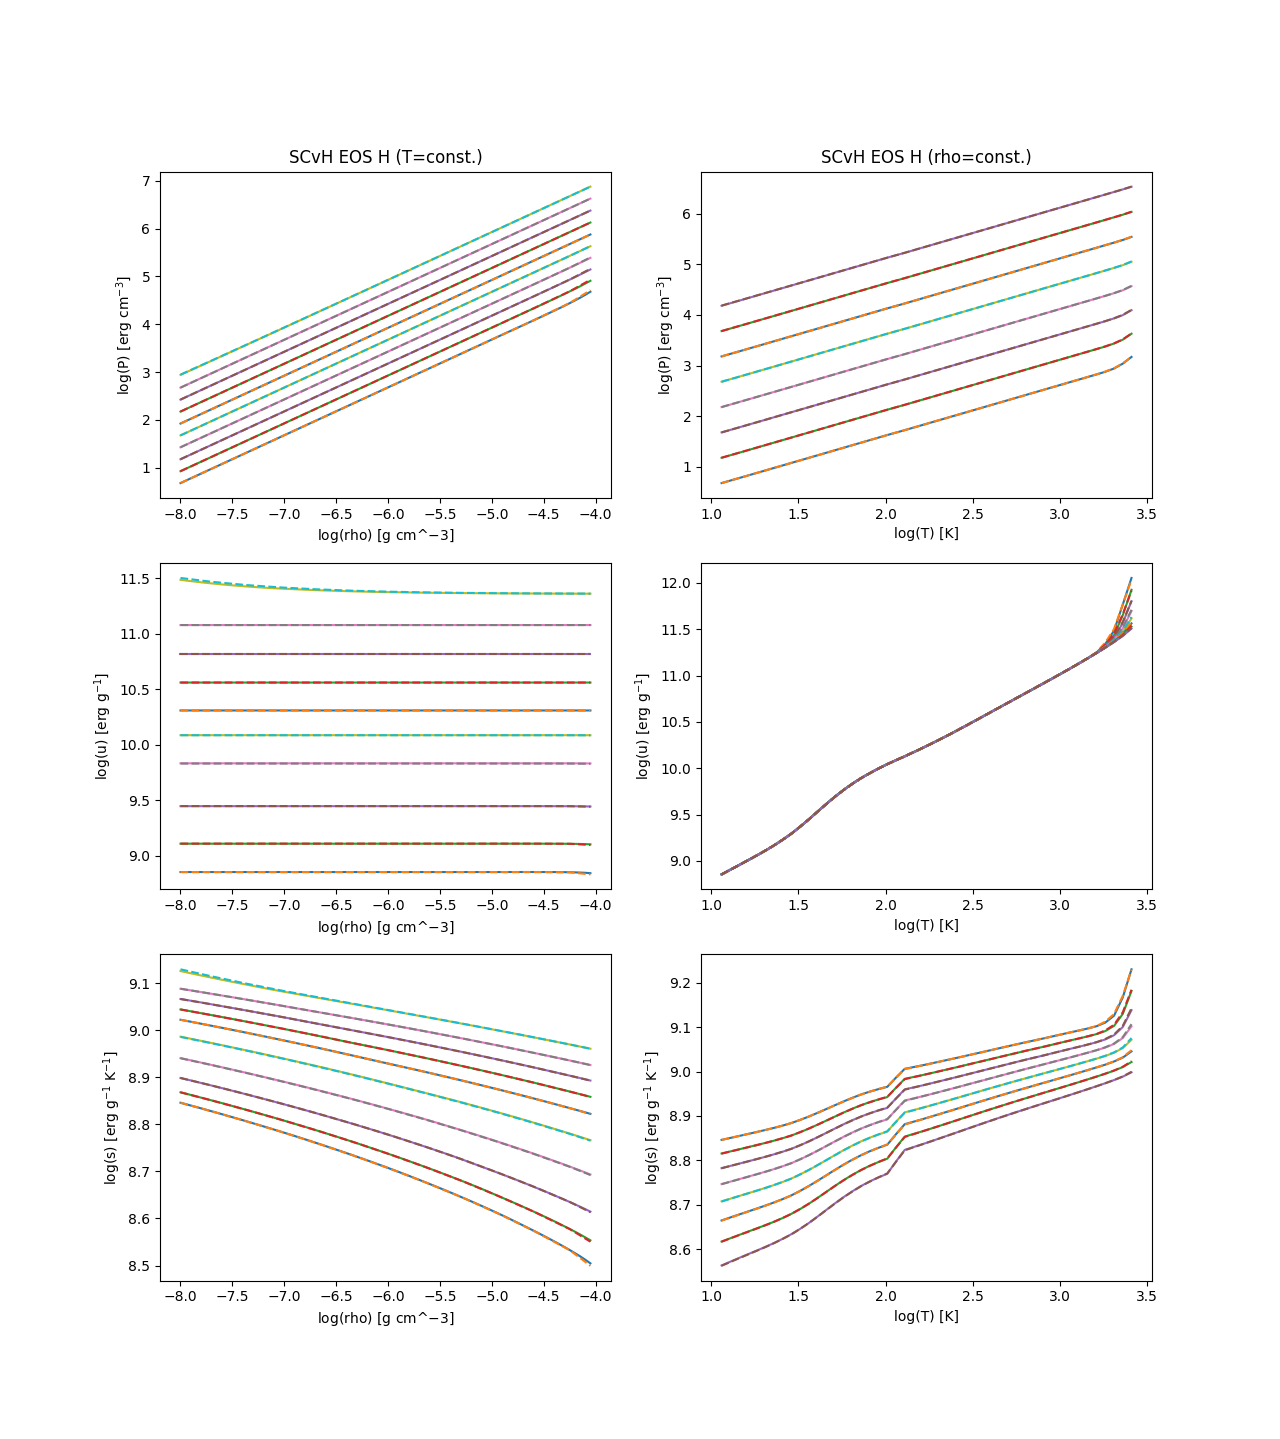

In [21]:
# Compare the inverted EOS table to the restricted EOS tables
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

# P(rho, T=const)
for i in range(0, nT_grid, nSkipT):
    ax[0][0].plot(logrho_grid, logP_grid[i,:], '-')
    ax[0][0].plot(logrho_grid, logP_int(logrho_grid, logT_grid[i]), '--')

ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
for i in range(0, nRho_grid, nSkipRho):
    ax[0][1].plot(logT_grid, logP_grid[:,i], '-')
    ax[0][1].plot(logT_grid, logP_int(logrho_grid[i], logT_grid), '--')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
for i in range(0, nT_grid, nSkipT):
    ax[1][0].plot(logrho_grid, logu_grid[i,:], '-')
    ax[1][0].plot(logrho_grid, logu_int(logrho_grid, logT_grid[i]), '--')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
for i in range(0, nRho_grid, nSkipRho):
    ax[1][1].plot(logT_grid, logu_grid[:,i], '-')
    ax[1][1].plot(logT_grid, logu_int(logrho_grid[i], logT_grid), '--')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
for i in range(0, nT_grid, nSkipT):
    ax[2][0].plot(logrho_grid, logs_grid[i,:], '-')
    ax[2][0].plot(logrho_grid, logs_int(logrho_grid, logT_grid[i]), '--')

ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
for i in range(0, nRho_grid, nSkipRho):
    ax[2][1].plot(logT_grid, logs_grid[:,i], '-')
    ax[2][1].plot(logT_grid, logs_int(logrho_grid[i], logT_grid), '--')

ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


nRho_extrap= 100 nRho_grid= 80
nT_extrap= 100 nT_grid= 48


IndexError: list index out of range

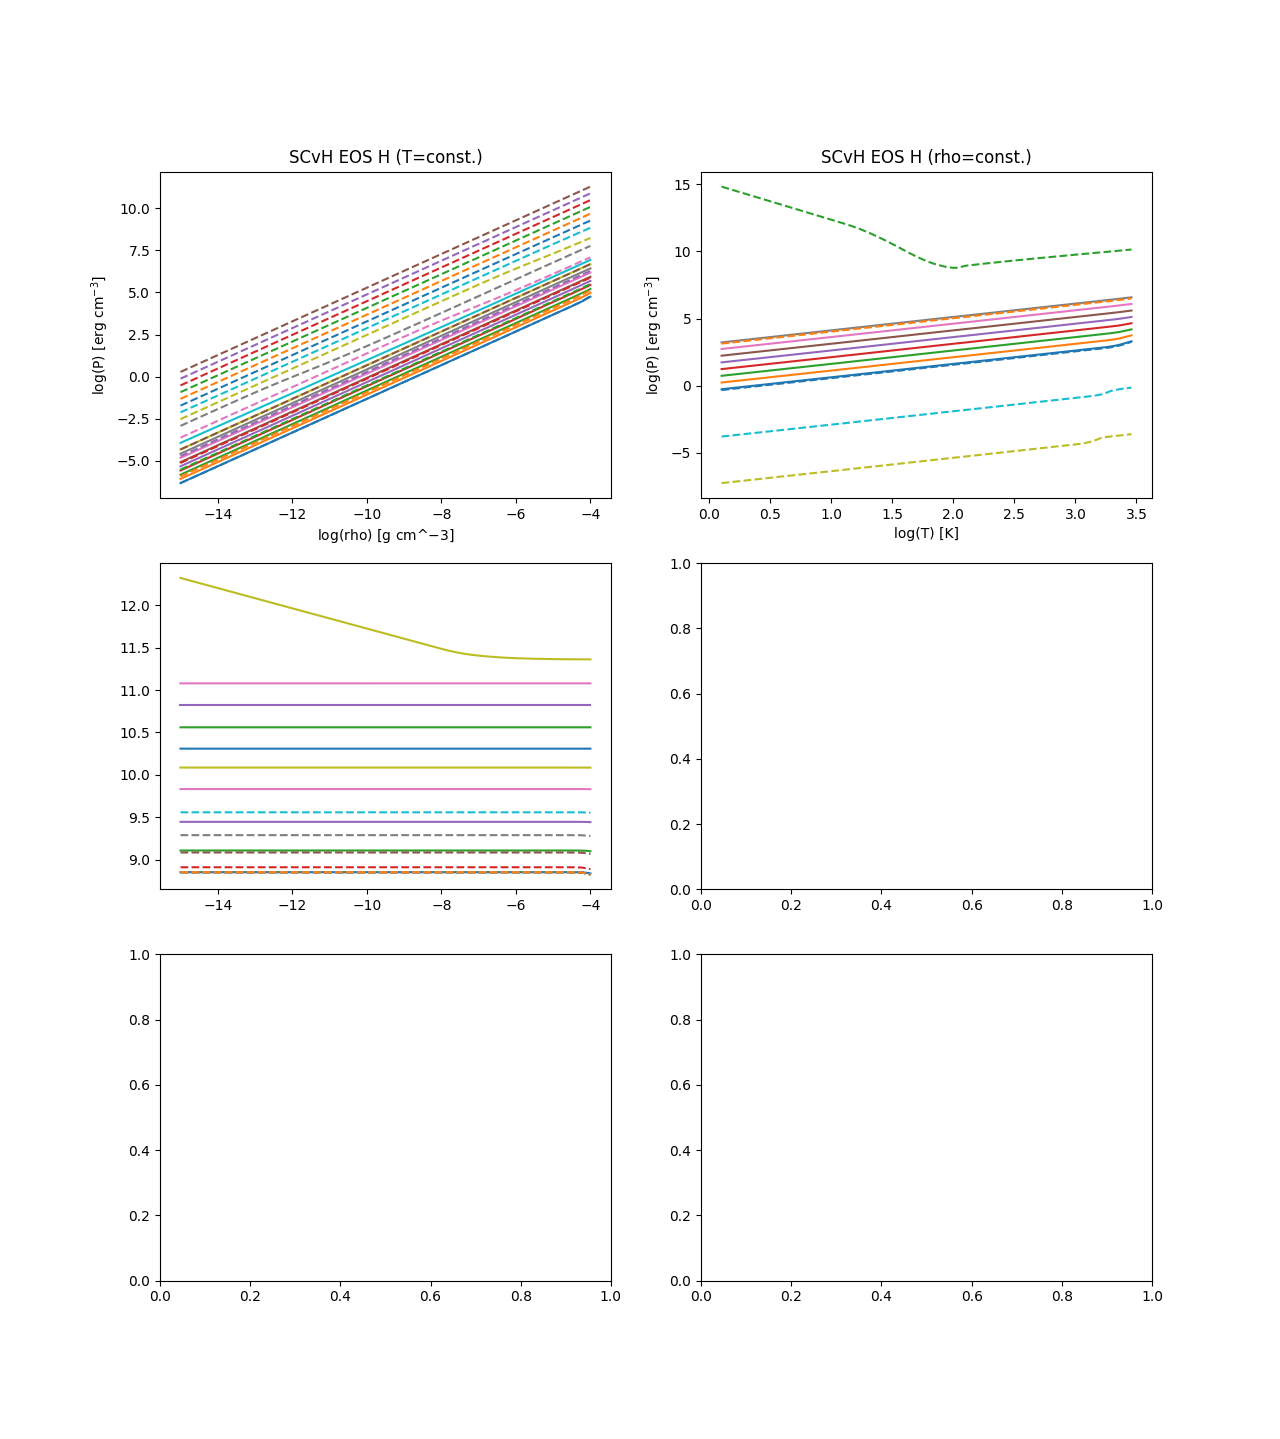

In [22]:
# Compare the inverted EOS table to the restricted EOS tables when extrapolating
fig, ax = plt.subplots(3, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 3*y)

nT_ext = np.size(logT_table_axis)
nRho_ext = np.size(logrho_axis)

# Isotherms
logP_of_logrho_grid_int = list()
logu_of_logrho_grid_int = list()
logs_of_logrho_grid_int = list()

logP_of_logrho_ext_int = list()
logu_of_logrho_ext_int = list()
logs_of_logrho_ext_int = list()

for i in range(0, nT_grid):
    logP_of_logrho_grid_int.append(interp.InterpolatedUnivariateSpline(logrho_grid, logP_grid[i,:], k=1, ext='extrapolate'))
    logu_of_logrho_grid_int.append(interp.InterpolatedUnivariateSpline(logrho_grid, logu_grid[i,:], k=1, ext='extrapolate'))
    logs_of_logrho_grid_int.append(interp.InterpolatedUnivariateSpline(logrho_grid, logs_grid[i,:], k=1, ext='extrapolate'))

for i in range(nT_ext):
    logP_of_logrho_ext_int.append(interp.InterpolatedUnivariateSpline(logrho_axis, logP_array[i,:], k=1, ext='extrapolate'))
    logu_of_logrho_ext_int.append(interp.InterpolatedUnivariateSpline(logrho_axis, logu_array[i,:], k=1, ext='extrapolate'))
    logs_of_logrho_ext_int.append(interp.InterpolatedUnivariateSpline(logrho_axis, logs_array[i,:], k=1, ext='extrapolate'))

# rho=const.
logP_of_logT_grid_int = list()
logu_of_logT_grid_int = list()
logs_of_logT_grid_int = list()

logP_of_logT_ext_int = list()
logu_of_logT_ext_int = list()
logs_of_logT_ext_int = list()

for i in range(0, nRho_grid):
    logP_of_logT_grid_int.append(interp.InterpolatedUnivariateSpline(logT_grid, logP_grid[:,i], k=1, ext='extrapolate'))
    logu_of_logT_grid_int.append(interp.InterpolatedUnivariateSpline(logT_grid, logu_grid[:,i], k=1, ext='extrapolate'))
    logs_of_logT_grid_int.append(interp.InterpolatedUnivariateSpline(logT_grid, logs_grid[:,i], k=1, ext='extrapolate'))

for i in range(0, nRho_ext):
    logP_of_logT_ext_int.append(interp.InterpolatedUnivariateSpline(logT_table_axis, logP_grid[:,i], k=1, ext='extrapolate'))
    logu_of_logT_ext_int.append(interp.InterpolatedUnivariateSpline(logT_table_axislogT_grid, logu_grid[:,i], k=1, ext='extrapolate'))
    logs_of_logT_ext_int.append(interp.InterpolatedUnivariateSpline(logT_grid, logs_grid[:,i], k=1, ext='extrapolate'))

logrho_axis_extrap = np.concatenate((np.linspace(-15.0, logrho_grid_min, 10), logrho_grid))
logT_axis_extrap = np.concatenate((np.linspace(0.1, logT_grid_min, 10), logT_grid))

nRho_extrap = np.size(logrho_axis_extrap)
nT_extrap = np.size(logT_axis_extrap)

print("nRho_extrap= {:} nRho_grid= {:}".format(nRho_extrap, nRho_grid))
print("nT_extrap= {:} nT_grid= {:}".format(nT_extrap, nT_grid))

#logrho_axis_extrap = np.linspace(-15.0, -4.0, nRho_grid)
#logT_axis_extrap = np.linspace(0.0, 3, nT_grid)

#logrho_axis_extrap = logrho_grid
#logT_axis_extrap = logT_grid
    
# P(rho, T=const)
for i in range(0, nT_grid, nSkipT):
    ax[0][0].plot(logrho_axis_extrap, logP_of_logrho_grid_int[i](logrho_axis_extrap), '-')
    
for i in range(0, nT_extrap, nSkipT):
    ax[0][0].plot(logrho_axis_extrap, logP_int(logrho_axis_extrap, logT_axis_extrap[i]), '--')

ax[0][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][0].set(title="SCvH EOS H (T=const.)")

# P(rho=const, T)
for i in range(0, nRho_extrap, nSkipRho):
    ax[0][1].plot(logT_axis_extrap, logP_of_logT_grid_int[i](logT_axis_extrap), '-')
    ax[0][1].plot(logT_axis_extrap, logP_int(logrho_axis_extrap[i], logT_axis_extrap), '--')

ax[0][1].set(xlabel="log(T) [K]", ylabel="log(P) [erg cm$^{-3}$]")
ax[0][1].set(title="SCvH EOS H (rho=const.)")

# u(rho, T=const)
for i in range(0, nT_extrap, nSkipT):
    ax[1][0].plot(logrho_axis_extrap, logu_of_logrho_grid_int[i](logrho_axis_extrap), '-')
    ax[1][0].plot(logrho_axis_extrap, logu_int(logrho_axis_extrap, logT_axis_extrap[i]), '--')

ax[1][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(u) [erg g$^{-1}$]")

# u(rho=const, T)
for i in range(0, nRho_extrap, nSkipRho):
    ax[1][1].plot(logT_axis_extrap, logu_of_logT_grid_int[i](logT_axis_extrap), '-')
    ax[1][1].plot(logT_axis_extrap, logu_int(logrho_axis_extrap[i], logT_axis_extrap), '--')

ax[1][1].set(xlabel="log(T) [K]", ylabel="log(u) [erg g$^{-1}$]")

# s(rho, T=const)
for i in range(0, nT_extrap, nSkipT):
    ax[2][0].plot(logrho_axis_extrap, logs_of_logrho_grid_int[i](logrho_axis_extrap), '-')
    ax[2][0].plot(logrho_axis_extrap, logs_int(logrho_axis_extrap, logT_axis_extrap[i]), '--')

ax[2][0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
for i in range(0, nRho_extrap, nSkipRho):
    ax[2][1].plot(logT_grid, logs_grid[:,i], '-')
    ax[2][1].plot(logT_grid, logs_int(logrho_grid[i], logT_grid), '--')

ax[2][1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")
